# Numerical Experiments on Feynman-Kac Formula

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from typing import Callable

## Introduction

Option pricing represents one of the biggest challenges in financial mathematics and is often formulated as a parabolic partial differential equation (PDE) - the celebrated Black Scholes PDE - under some restrictive assumptions (e.g. no transaction cost, constant volatility & risk-free rate, etc.), as shown below:

\begin{aligned}
\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + rS\frac{\partial V}{\partial S} - rV = 0
\end{aligned}

where $V(t, S)$ is the price of the option as a function of stock price S and time t, r is the risk-free interest rate, and $\sigma$ is the (implied) volatility of the stock.

In addition, to be able to solve this PDE, we will need to impose a "terminal" boundary condition: $V(T, s) = Payoff(s), \forall s$ where $Payoff(S_T)$ is the payoff of the option depending on the value taken by the stock at the maturity $T$ of the option.

The Feynman-Kac formula, rooted in quantum mechanics and statistical physics, now plays a role. It bridges between PDEs and stochastic processes:
\begin{aligned}
dS_t = rS_tdt + \sigma dW_t^{\mathbb{Q}}, 0 \leq t \leq T
\end{aligned}
and then allows us to represent the solution of the PDE as an expectation under the risk-neutral measure $\mathbb{Q}$

The advantage of having a probabilistic represention of the solution is that we can then approximate the expectation using Monte Carlo sampling under the equivalent stochastic process. This can be easier than deriving an analytical solution of the PDE.

Under the standard Black-Scholes assumptions, the application of the Feynman-Kac formula has a very solid theoretical ground. However, when people start to relax the assumptions, e.g. replacing $r$ with $b(t, X_t)$ or $\sigma$ with $\sigma(t, X_t)$ and hope the Feynman-Kac formula still works for any choice of $b(t, X_t)$ and $\sigma(t, X_t)$ without additional mathematical justification, things start to be chaotic. This is a typical illusion for finance students who are usually not very mathematically minded.

Incorrect application of Feynman-Kac theorem can lead to very wrong option pricing, which could be translated to a huge loss of one's options book.

Through a series of numerical experiments, this notebook serves the purpose of reminding people of the pitfalls of applying the Feynman-Kac formula and the importance of knowing the assumptions of the theorem they use.

## Existence and Uniqueness of Solutions to SDEs

In the preparation for stating the Feynman-Kac formula, first we introduce several notations:

(1) $b(t, x): [0, T] \times \mathbb{R}^d \rightarrow \mathbb{R}^d$ is a Borel measurable function of $(t, x)$

(2) $\sigma(t, x) = (\sigma_{ij}(t, x), i \in \{1,...,d\}$ and $j \in \{1,...,m\})$ is $d \times m$ matrix function such that each $\sigma_{ij}(t, x): [0, T] \times \mathbb{R}^d \rightarrow \mathbb{R}^d$ is Borel measureable

(3) $|b|^2 = \sum_{i=1}^d (b_i)^2$ and $||\sigma||^2 = \sum_{i=1}^d \sum_{j=1}^m \sigma_{ij}^2$

(4) $dX_t = b(t, X_t)dt+\sigma(t, X_t)dW_t, 0 \leq t \leq T, X_0 = \xi$

(5) $W = (W^1, ... W^m)$ is an $m$-dimensional standard Wiener process defined on a probability basis $(\Omega, \mathcal{F}, (\mathcal{F})_t, P)$ such that $(W_t, \mathcal{F}_t)$ is a martingale and $\xi$ is a $d$-dimensional random variable on $(\Omega, \mathcal{F}, P)$ independent of $W$.

(6) $X_t = X_0 + \int_0^t b(s, X_s)ds + \int_0^t \sigma(s, X_s)dW_s, 0 \leq t \leq T$


Theorem 1: **Existence and Uniqueness of Solutions**

Let the coefficient functions $b$ and $\sigma$ satisfy the following conditions: There exists a positive constant $K_T$ such that for $0 \leq t \leq T$, and $x, y \in \mathbb{R}^d$,

Lipschitz condition: $|b(t, x) - b(t, y)|^2 + \lVert \sigma(t, x)-\sigma(t, y) \rVert^2 \leq K_T|x-y|^2$

Growth condition: $|b(t, x)|^2 + \lVert \sigma(t, x) \rVert^2 \leq K_T(1+|x|^2)$

Also let $E[|\xi|^2] < \infty$

Then the SDE (4) has a **unique** solution $(X_t), 0 \leq t \leq T$ on the given probability space such that

(7)$X_0 = \xi$ a.s.

$X$ as defined in (6) has the following additional properties: 

(8) $X$ is adapted to $(\mathcal{F}_t)$

(9) $E\Bigl[ \int_0^T \bigl( |b(t, X_t)|^2 + \lVert \sigma(t, X_t) \rVert^2 \bigl) dt \Bigl] < \infty$

The process $X$ satisfying (6), (7), (8) and (9) is called a **strong solution**.

**Interpretation**

The mathematics in this theorem might look intimidating, but we can break it down into a simple, intuitive picture. Imagine the process $X_t, 0 \leq t \leq T$, as a random path a particle traces through space over time—like a wobbly line drawn on a sheet of paper. This path isn’t just any wild scribble; the theorem ensures it behaves in a controlled, predictable way.

For this random path to make sense physically or mathematically, we need two things: its average position (the expected value $E[X_t]$) and its spread (the variance $Var[X_t]$) should be well-defined at every moment $t$. Indeed, **the strong solution from Theorem 1 ensures the expectation in Theorem 2 [Feynman-Kac formula] is well-defined!**

To achieve this, the theorem imposes two key rules on the "forces" guiding the particle—represented by the functions $b$ (the drift, like a steady push) and $\sigma$ (the diffusion, like random jiggling):

Lipschitz condition: This is about smoothness and stability. It says that if two particles start close to each other, the forces $b$ and $\sigma$ acting on them won’t differ too wildly. Think of it as a rule that prevents the path from suddenly jerking apart when tiny changes occur—keeping the motion "reasonably tame" and ensuring there’s only one possible path (uniqueness).

Growth condition: This controls how fast the path can stretch or wiggle as the particle moves farther out. It ensures the forces $b$ and $\sigma$ don’t grow uncontrollably large, so the particle doesn’t shoot off to infinity or oscillate chaotically. This keeps the path’s energy (in a mathematical sense) finite and manageable.

Here we create a function for monte carlo simulation for arbitrary $b$ and $\sigma$ and use it to simulate Geometric Brownian Motion (GBM) which is known to have a strong solution. 

In [16]:
def monte_carlo_simulation(
    X0: float,
    T: float,
    b_func: Callable,
    sigma_func: Callable,
    N: int = 100,
    M: int = 10000) -> np.ndarray:
    '''
    Simulates paths of a stochastic process dX_t = b(t, X_t) dt + sigma(t, X_t) dW_t
    using the Euler-Maruyama method.
    
    Parameters
    ----------
    X0: float, Initial value of the process
    b_func: function, Drift function b(t, X_t)
    sigma_func: function, Volatility function sigma(t, X_t)
    T: T, Total simulation time
    N: int, optional, Number of time steps (default: 100)
    M: int, optional, Number of simulated paths (default: 10000)
    
    Returns
    -------
    np.ndarray, Simulated paths of shape (M, N+1)
    '''
    dt = T / N
    X = np.zeros((M, N+1))
    X[:, 0] = X0 
    
    for i in range(N):
        t = i * dt
        dW = np.sqrt(dt) * np.random.randn(M)  # Brownian increments
        X[:, i+1] = X[:, i] + b_func(t, X[:, i]) * dt + sigma_func(t, X[:, i]) * dW
    
    return X

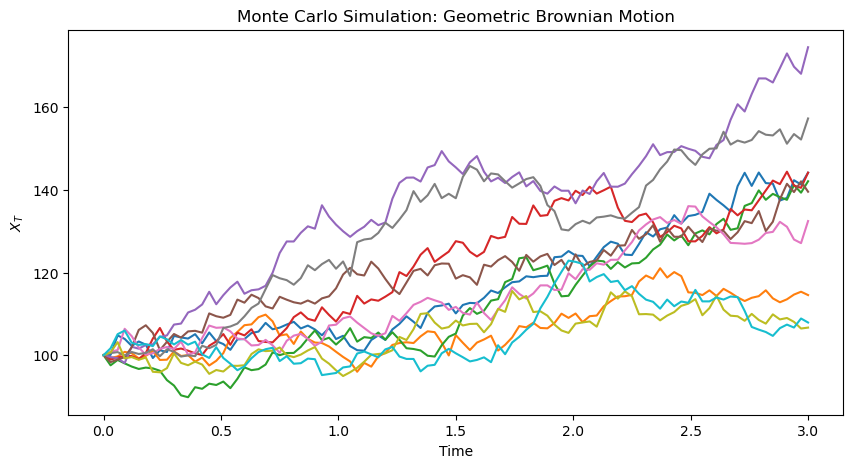

In [17]:
X0 = 100
T = 3
mu = 0.08
sigma = 0.1
gbm_b = lambda t, X: mu * X
gbm_sigma = lambda t, X: sigma * X
N = 100
M = 10000

# Simulate Geometric Brownian Motion
gbm_paths = monte_carlo_simulation(X0, T, gbm_b, gbm_sigma, N, M)

# Plot sample paths
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0, T, N+1), gbm_paths[:10, :].T)
plt.xlabel("Time")
plt.ylabel("$X_T$")
plt.title("Monte Carlo Simulation: Geometric Brownian Motion")
plt.show()

## Feynman-Kac Formula

With a few more notations, we can then state the Feynman-Kac theorem.

(10) $a(t, x) = \sigma(t, x)\sigma^*(t, x)$ (Note: this is a matrix!)

(11) $A_t := \frac{\partial}{\partial t}+\frac{1}{2}\sum_{i, j=1}^d a_{ij}(t, x)\frac{\partial^2}{\partial x_i \partial x_j}+\sum_{i=1}^d b_i(t, x)\frac{\partial}{\partial x_i}$ is a differential operator acting on $C^{1, 2}([0, T] \times \mathbb{R}^d)$

(12) $\{X^{s, x}_t: s \leq t \leq T\}$ is the solution to the SDE defined as (4) for $t \in [s, T]$ with $X^{s, x}_s = x$

(13): $P_{s, x}$ denotes the law of $X^{s, x}$ on $C([s, T], \mathbb{R}^d)$

(14): $\xi_t$ is the coordinate process on $P_{s, x}$ 

(15): $c: [0, T] \times \mathbb{R}^d \rightarrow [0, \infty)$ is a continuous function

(16): $A_tv = cv$ on $(0, T) \times \mathbb{R}^d$

Theorem 2: **Feynman-Kac formula**

Suppose $v \in C([0, T] \times \mathbb{R}^d) \cap C^{1, 2}((0, T) \times \mathbb{R}^d)$ is a solution to the PDE (16) satisfying

\begin{aligned}
|v(t, x)| \leq C(1+|x|^\lambda)
\end{aligned}

for some $C < \infty, \lambda < \infty$. Then for $(s, x) \in [0, T) \times \mathbb{R}^d$,

\begin{aligned}
v(s, x) = E_{P_{s, x}}\Bigl[ v(T, \xi_T) \exp \bigl(\int_s^T -c(v, \xi_u) du \bigl) \Bigl]
\end{aligned}


## Financial Application 1: European Option Pricing under GBM

Now we have already set the stage for pricing European options under Black-Scholes assumptions. The option price can then be calculated as a risk-neutral expectation of payoff at maturity discounted by the risk-free rate, which can then be estimated by sampling $dS_t = rS_tdt + \sigma dW_t^{\mathbb{Q}}, 0 \leq t \leq T$

\begin{aligned}
V(t, S_t) = E_{\mathbb{Q}}\Bigl[ Payoff(S_T) \exp \bigl(-r(T-t)\bigl) \Bigl] = \exp \bigl(-r(T-t)\bigl) E_{\mathbb{Q}}\Bigl[ Payoff(S_T) \Bigl]
\end{aligned}

In [30]:
def black_scholes_european_call(
    S: float,
    K: float,
    T: float,
    r: float,
    sigma: float) -> float:
    '''
    Compute the price of an European call using the Black Scholes formula

    Parameters
    ----------
    S : float
        Current commodity price
    K : float
        Strike price
    T : float
        Time to maturity (in years)
    r : float
        Risk-free rate
    sigma : float
        Volatility of the underlying asset
    
    Returns
    -------
    float
    '''
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


In [31]:
def mc_european_call(
    S: float,
    K: float,
    T: float,
    r: float,
    sigma: float,
    N: int = 100,
    M: int = 10000) -> float:
    '''
    Compute the price of an European call using the Black Scholes formula

    Parameters
    ----------
    S : float
        Current commodity price
    K : float
        Strike price
    T : float
        Time to maturity (in years)
    r : float
        Risk-free rate
    sigma : float
        Volatility of the underlying asset
    N: int, optional, Number of time steps (default: 100)
    M: int, optional, Number of simulated paths (default: 10000)
    
    Returns
    -------
    float
    '''
    gbm_b = lambda t, S: r * S
    gbm_sigma = lambda t, S: sigma * S

    np.random.seed(42)
    gbm_paths = monte_carlo_simulation(S, T, gbm_b, gbm_sigma, N, M)

    option_price = np.exp(-r * T) * np.mean(np.maximum(gbm_paths[:,-1] - K, 0))
    
    return option_price

In [32]:
S_arr = np.arange(50, 151)
black_scholes_european_call_arr = []
mc_european_call_arr = []
for S in S_arr:
    black_scholes_european_call_arr.append(black_scholes_european_call(S, 100, 3, 0.02, 0.1))
    mc_european_call_arr.append(mc_european_call(S, 100, 3, 0.02, 0.1))

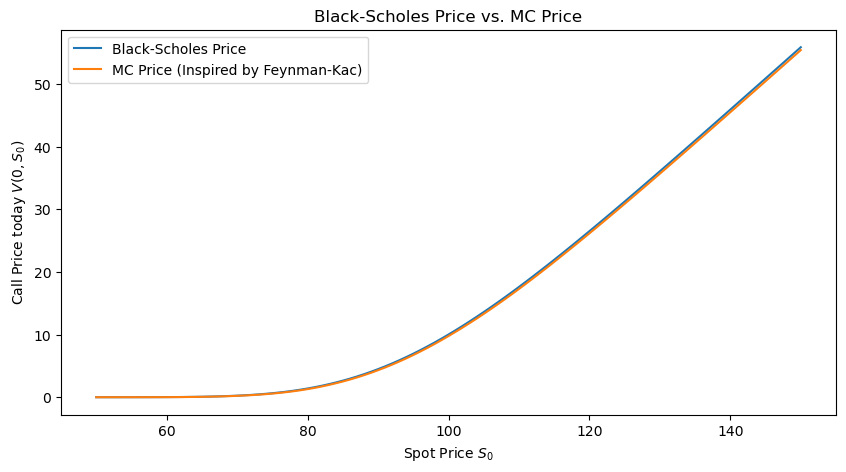

In [33]:
plt.figure(figsize=(10,5))
plt.plot(S_arr, black_scholes_european_call_arr, label='Black-Scholes Price')
plt.plot(S_arr, mc_european_call_arr, label='MC Price (Inspired by Feynman-Kac)')
plt.legend()
plt.xlabel("Spot Price $S_0$")
plt.ylabel("Call Price today $V(0, S_0)$")
plt.title("Black-Scholes Price vs. MC Price")
plt.show()

## Financial Application 2: Ornstein-Uhlenbeck (OU) Process

In modeling the dynamics of the short-term interest rate $r_t$, a commonly adopted SDE is the Ornstein-Uhlenbeck (OU) process. This model captures a key empirical feature of interest rates: mean reversion. When $r_t$ strays from its long-term mean $\mu$, the process pulls it back over time, governed by the reversion speed $\theta$. This behavior aligns well with real-world observations, making the OU process a staple in interest rate modeling, such as in the Vasicek model.

The SDE for the short rate under the risk-neutral measure $\mathbb{Q}$ is:

\begin{aligned}
dr_t = \theta(\mu - r_t) dt + \sigma dW^\mathbb{Q}_t, 0 \leq t \leq T
\end{aligned}

Here, $\theta>0$ controls the speed of reversion and $\mu$ is the long-term mean.

We would use the Feynman-Kac formula to explore the statistical properties of $r_t$ by Monte Carlo Simulation and compare the results with the analytical solutions:

$E[r_t] = \mu + (r_0 - \mu) * \exp{(-\theta t)}$

$Var[r_t] = \frac{\sigma^2}{2\theta}\Bigl(1-\exp{(-2\theta t)}\Bigl)$

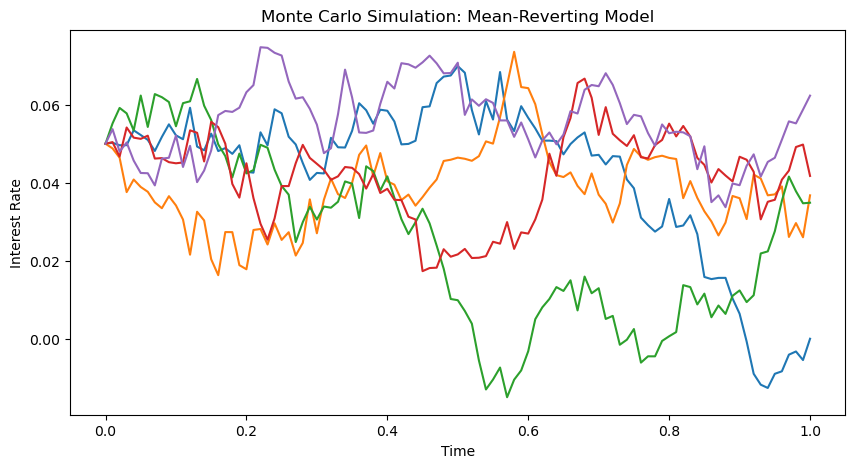

In [36]:
theta = 2
mu = 0.02
sigma = 0.05
ou_b = lambda t, r: theta * (mu - r)
ou_sigma = lambda t, r: sigma
T = 1.0
N = 100
M = 10000
r0 = 0.05

# Simulate Ornstein-Uhlenbeck Model
ou_paths = monte_carlo_simulation(r0, T, ou_b, ou_sigma, N, M)

# Plot Sample Paths
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0, T, N+1), ou_paths[:5, :].T)
plt.xlabel("Time")
plt.ylabel("Interest Rate")
plt.title("Monte Carlo Simulation: Mean-Reverting Model")
plt.show()


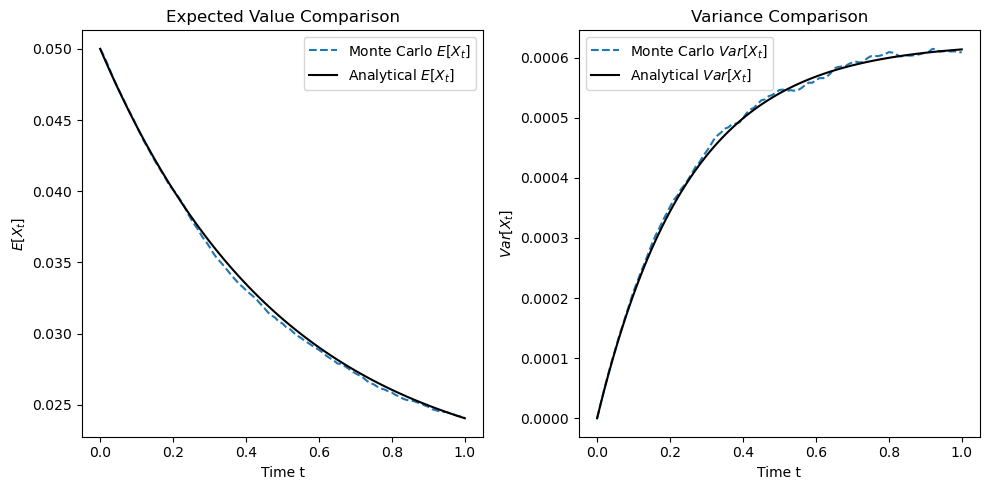

In [37]:
t = np.linspace(0, T, N+1)

# Compute Monte Carlo estimates
E_rt_mc = np.mean(ou_paths, axis=0)
Var_rt_mc = np.var(ou_paths, axis=0)

# Analytical solutions
E_rt_exact = mu + (r0 - mu) * np.exp(-theta * t)
Var_rt_exact = (sigma**2 / (2 * theta)) * (1 - np.exp(-2 * theta * t))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(t, E_rt_mc, label='Monte Carlo $E[X_t]$', linestyle='dashed')
plt.plot(t, E_rt_exact, label='Analytical $E[X_t]$', color='black')
plt.xlabel('Time t')
plt.ylabel('$E[X_t]$')
plt.legend()
plt.title('Expected Value Comparison')
plt.subplot(1, 2, 2)
plt.plot(t, Var_rt_mc, label='Monte Carlo $Var[X_t]$', linestyle='dashed')
plt.plot(t, Var_rt_exact, label='Analytical $Var[X_t]$', color='black')
plt.xlabel('Time t')
plt.ylabel('$Var[X_t]$')
plt.legend()
plt.title('Variance Comparison')
plt.tight_layout()
plt.show()

A zero-coupon bond pays 1 dollar at maturity $T$ and nothing before that. Its price at time $t$ is the present value of that 1 dollar, discounted by the short-term interest rate $r_s$ over the period $[0, T]$. When the interest rate is stochastic (like in the OU process), we use a risk-neutral framework and the Feynman-Kac formula to express the bond price as an expectation.

We can formulate the pricing problem as the following PDE:

\begin{aligned}
\frac{\partial P}{\partial t} + \frac{1}{2}\sigma^2 \frac{\partial^2 P}{\partial r^2} + \theta(\mu - r)\frac{\partial P}{\partial r} - rP = 0
\end{aligned}

with a boundary condition:
\begin{aligned}
P(T, r) = 1
\end{aligned}

This boundary value problem has a known solution:
\begin{aligned}
P(0, T) = A(T) \exp{(-B(T)r_0)}
\end{aligned}
where:

$B(T) = \frac{1-\exp{(-\theta T)}}{\theta}$

$A(T) = \exp{\bigl( \frac{(B(T)-T)(\theta^2 \mu - \frac{1}{2} \sigma^2)}{\theta^2} - \frac{\sigma^2 B(T)^2}{4 \theta} \bigl)}$

In [39]:
def mc_bond(
    r0: float,
    theta: float,
    mu: float,
    sigma: float,
    T: float,
    N: int = 100,
    M: int = 10000) -> float:
    
    ou_b = lambda t, r: theta * (mu - r)
    ou_sigma = lambda t, r: sigma
    
    ou_paths = monte_carlo_simulation(r0, T, ou_b, ou_sigma, N, M)
    
    dt = T / N
    integral_r = np.cumsum(ou_paths, axis=1) * dt
    discount = np.exp(-integral_r)
    bond_price = np.mean(discount[:, -1])
    return bond_price

def vasicek_bond(
    r0: float,
    theta: float,
    mu: float,
    sigma: float,
    T: float) -> float:
    B = (1 - np.exp(-theta * T)) / theta
    A = np.exp(((B - T) * (theta**2 * mu - 0.5 * sigma**2)) / theta**2 - (sigma**2 * B**2) / (4 * theta))
    bond_price = A * np.exp(-B * r0)
    return bond_price
    

In [40]:
r0 = 0.3
theta = 2
mu = 0.02
sigma = 0.05
T = 1

r_arr = np.arange(0.01, r0+0.01, 0.01)
mc_bond_arr = []
vasicek_bond_arr = []

for r in r_arr:
    mc_bond_arr.append(mc_bond(r, theta, mu, sigma, T))
    vasicek_bond_arr.append(vasicek_bond(r, theta, mu, sigma, T))

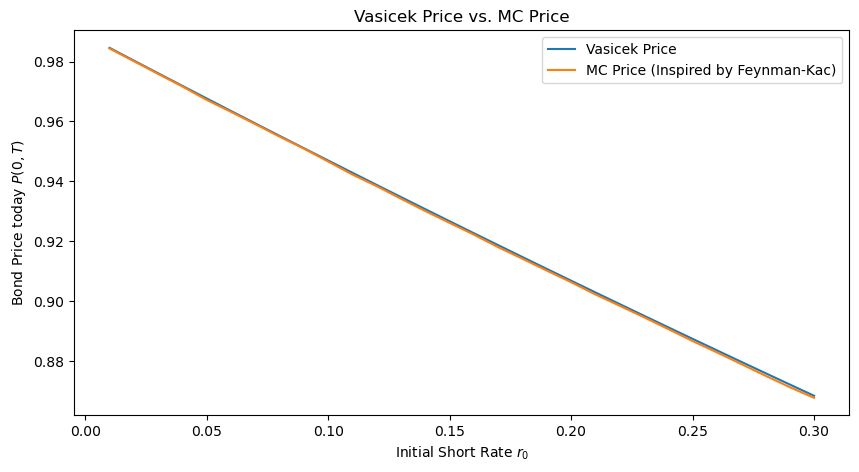

In [41]:
plt.figure(figsize=(10,5))
plt.plot(r_arr, vasicek_bond_arr, label='Vasicek Price')
plt.plot(r_arr, mc_bond_arr, label='MC Price (Inspired by Feynman-Kac)')
plt.legend()
plt.xlabel("Initial Short Rate $r_0$")
plt.ylabel("Bond Price today $P(0, T)$")
plt.title("Vasicek Price vs. MC Price")
plt.show()

## Where the Feynman-Kac Formula is Not Applicable

### Case 1: Superlinear Growth

Consider the SDE: $dX_t = X_t^2 dt + dW_t$

The drift function $b(t, x) = x^2$ is **not Lipschitz continuous** . Also it violates the **growth condition**. Hence the strong solution does not exist.

Indeed when we simulate $X_t$, we would encounter an overflow issue.

/var/folders/jz/_62zm7jn3y754w_n7gcp4v3m0000gn/T/ipykernel_8297/3691021905.py:3: RuntimeWarning: overflow encountered in square
  superlinear_b_func = lambda t, X: X**2


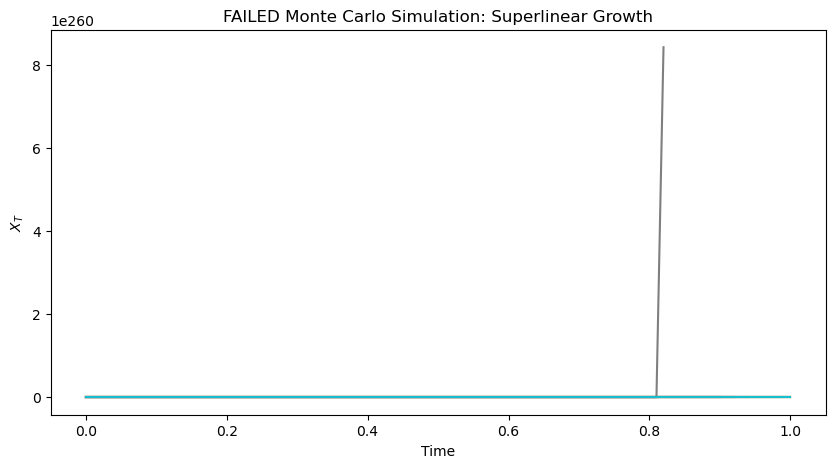

In [45]:
X0 = 1
T = 1
superlinear_b_func = lambda t, X: X**2
superlinear_sigma_func = lambda t, X: 1
N = 100
M = 10000
superlinear_paths = monte_carlo_simulation(X0, T, superlinear_b_func, superlinear_sigma_func, N, M)

# Plot sample paths
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0, T, N+1), superlinear_paths[:10, :].T)
plt.xlabel("Time")
plt.ylabel("$X_T$")
plt.title("FAILED Monte Carlo Simulation: Superlinear Growth")
plt.show()

### Case 2: Discontinuous Drift

Consider another SDE: $dX_t = sign(X_t) dt + dW_t$

The drift function $b(t, x) = sign(x)$ is **not continuous** . There is no unique solution for this SDE.

For a SDE which has a strong solution, we expect $E[X_t]$ (estimated by average $X_t$) is similar for each run (for all $t$), GBM being an example as shown below:

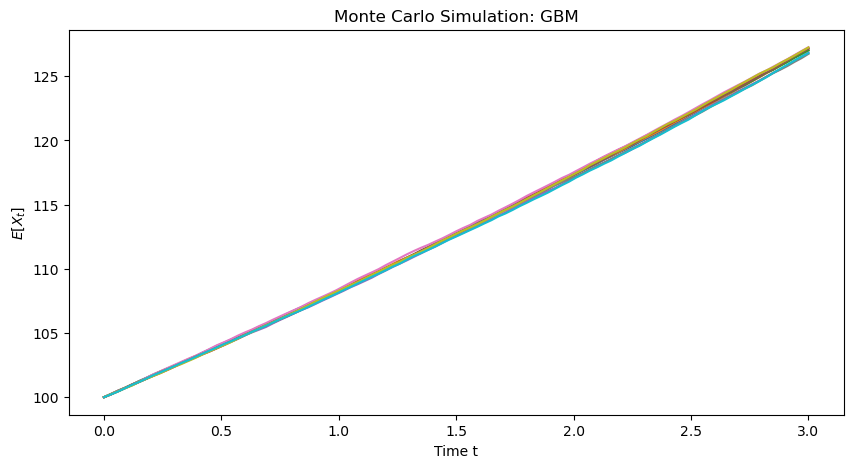

In [49]:
X0 = 100
T = 3
mu = 0.08
sigma = 0.1
gbm_b = lambda t, X: mu * X
gbm_sigma = lambda t, X: sigma * X
N = 100
M = 10000

# Plot sample paths
plt.figure(figsize=(10,5))
for _ in range(10):
    gbm_paths = monte_carlo_simulation(X0, T, gbm_b, gbm_sigma, N, M)
    plt.plot(np.linspace(0, T, N+1), np.mean(gbm_paths, axis=0))
plt.xlabel('Time t')
plt.ylabel('$E[X_t]$')
plt.title('Monte Carlo Simulation: GBM')
plt.show()

However, for $dX_t = sign(X_t) dt + dW_t$, when setting $X_0 = 0$, the average $E[X_t]$ is different for each run ...

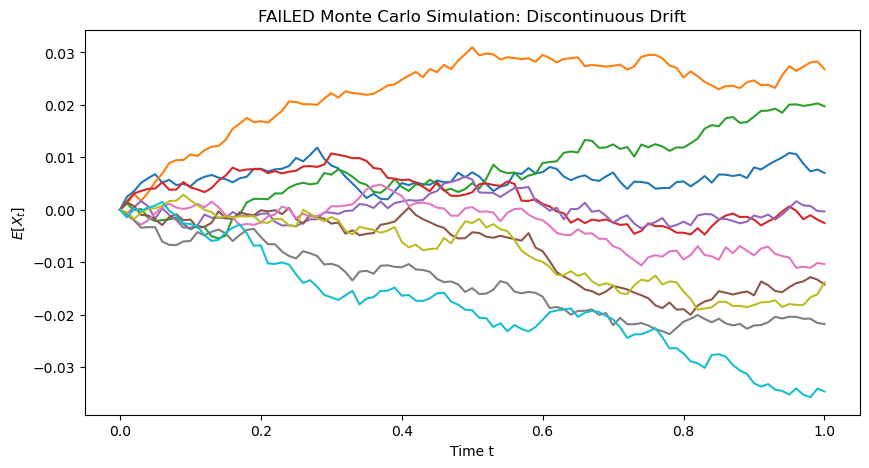

In [51]:
X0 = 0
T = 1
discontinuous_drift_b_func = lambda t, X: np.sign(X)
discontinuous_drift_sigma_func = lambda t, X: 1
N = 100
M = 10000

# Plot sample paths
plt.figure(figsize=(10,5))
for _ in range(10):
    discontinuous_drift_paths = monte_carlo_simulation(X0, T, discontinuous_drift_b_func, discontinuous_drift_sigma_func, N, M)
    plt.plot(np.linspace(0, T, N+1), np.mean(discontinuous_drift_paths, axis=0))
plt.xlabel('Time t')
plt.ylabel('$E[X_t]$')
plt.title('FAILED Monte Carlo Simulation: Discontinuous Drift')
plt.show()

Surprisingly, setting $X_0 = 1$, we can instead have a fairly nice convergence...

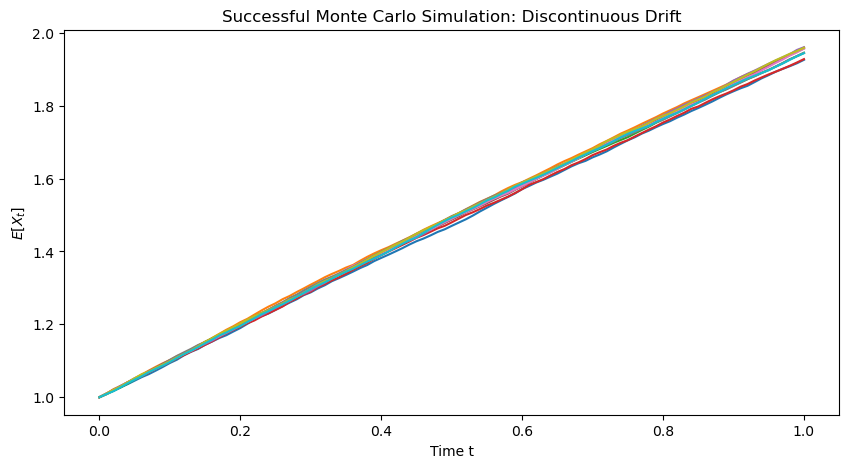

In [53]:
X0 = 1

plt.figure(figsize=(10,5))
for _ in range(10):
    discontinuous_drift_paths = monte_carlo_simulation(X0, T, discontinuous_drift_b_func, discontinuous_drift_sigma_func, N, M)
    plt.plot(np.linspace(0, T, N+1), np.mean(discontinuous_drift_paths, axis=0))
plt.xlabel('Time t')
plt.ylabel('$E[X_t]$')
plt.title('Successful Monte Carlo Simulation: Discontinuous Drift')
plt.show()

## Conclusion

The Feynman-Kac formula is a cornerstone of financial mathematics, elegantly linking stochastic processes to PDEs for pricing derivatives like options and bonds. Through numerical experiments, we’ve seen its power in action: under Black-Scholes, it accurately prices European calls via Monte Carlo, matching analytical solutions; in the Vasicek model, it captures mean-reverting interest rates to value zero-coupon bonds with precision. These successes rest on the SDE having a unique strong solution, as guaranteed by Theorem 1’s Lipschitz and growth conditions.

Yet, our journey also reveals the formula’s limits. When assumptions break—such as with the superlinear drift causing explosive paths, or the discontinuous sign leading to unstable expectation estimates. These failure cases underscore a critical lesson: applying the formula without verifying its mathematical foundations can lead to chaos, from overflow errors to unreliable prices.

For students and practitioners, this notebook is a reminder: know your tools. The Feynman-Kac formula shines when conditions hold, offering a flexible Monte Carlo approach to complex problems. But step beyond its bounds, and the results can unravel. Armed with this understanding, we can wield stochastic methods confidently—or recognize when to pivot to alternatives.